<a href="https://colab.research.google.com/github/pouyashojaei/datathon-code/blob/Pouya/WiDS_Texas_jayeon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WiDS hackathon

Jayeon Kim

In [90]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dense, Flatten, LSTM, Conv2D
from tensorflow.keras import Model, Sequential

file_north = 'north_electricity_weather_history.csv'
file_south_central = 'south_central_electricity_weather_history.csv'

files = [file_north, file_south_central]
dfs = [pd.read_csv(file) for file in files]

for df in dfs:
  df['Month'] = pd.DatetimeIndex(df['index']).month
  #df['Day'] = pd.DatetimeIndex(df['index']).day
  df['Hour'] = pd.DatetimeIndex(df['index']).hour
  #df[['Hour', 'Month']] = df[['Hour', 'Month']].astype('category')

## What does the data look like?

### Last four weeks

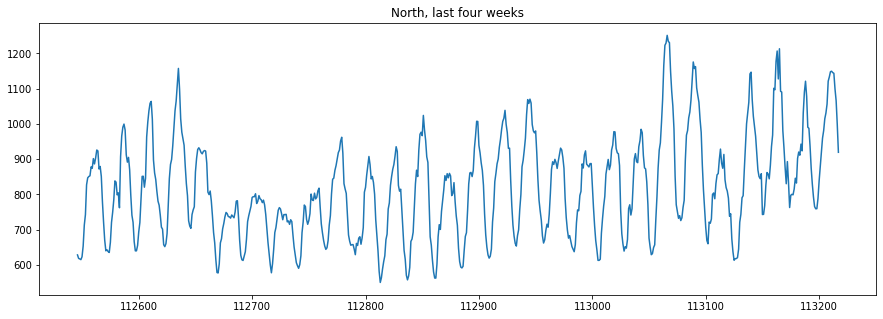

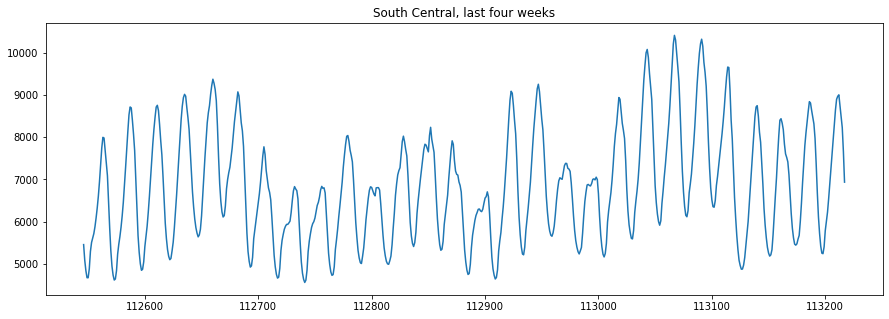

In [92]:
for df in dfs:
  df = df.reset_index()
  df = df.drop(['level_0', 'index'], axis=1)

  t = 24 * 7 * 4
  plt.figure(figsize=(15,5))
  plt.title(f'{df.columns[0]}, last four weeks')
  plt.plot(df.iloc[-t:,0])
  plt.show()

### For the month of June

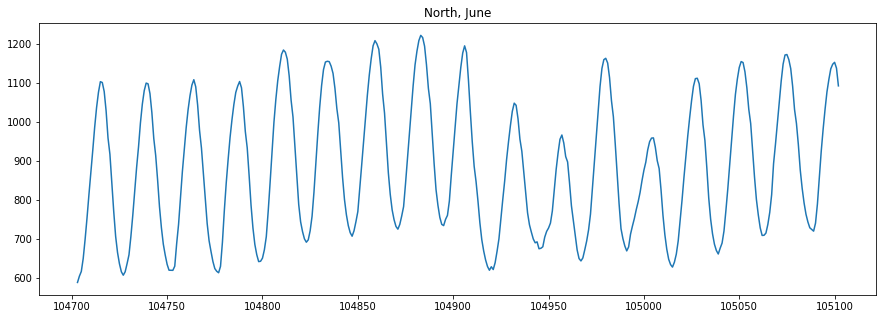

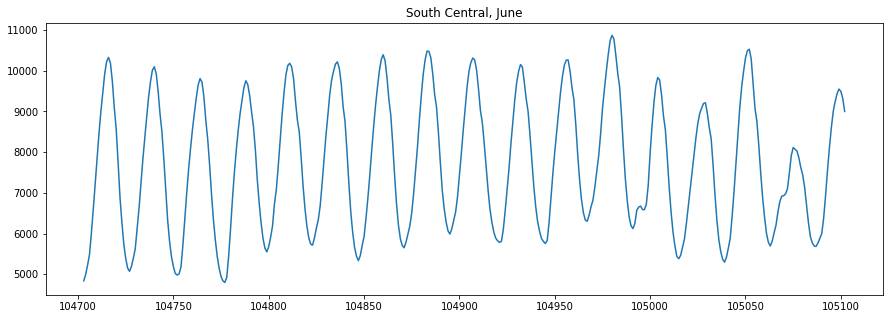

In [98]:
for df in dfs:
  df = df.reset_index()
  df = df.drop(['level_0', 'index'], axis=1)

  plt.figure(figsize=(15,5))
  plt.title(f'{df.columns[0]}, June')
  plt.plot(df[df['Month'] == 6].iloc[-500:-100,0])
  plt.show()

## Feature selection
### Part 1: Which features are correlated with which?
Now let us do some feature selection using the correlation matrix.

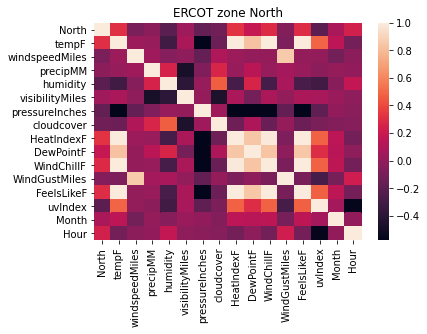

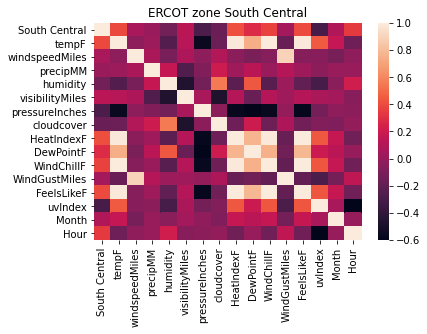

In [89]:
def view_heatmap(df):
  corr = df.corr()
  
  plt.figure()
  plt.title(f'ERCOT zone {df.columns[0]}')
  sns.heatmap(corr)
  plt.show()

for df in dfs:
  df = df.reset_index()
  df = df.drop(['level_0', 'index'], axis=1)
  
  view_heatmap(df)


Looking at the heatmaps for three ERCOT zones, we see that the correlation of predictor features and the target feature is not the same for every ERCOT zone. Generally, the correlation between the target feature and predictor features appears weaker in ERCOT zones located in the west. Perhaps this is because western Texas is less susceptible to extreme weather? (compared to coastal Texas that would see a lot of hurricanes). 

Generally, features with stronger correlation appear to be tempF, HeatIndexF, DewPointF, WindChillF and FeelsLikeF, whereas there appears to be a strong negative correlation between electricity demand and uvIndex. This is likely because electricity supply levels sharply decrease during nighttime (when UV levels are lower).

### Part 2: Check for low-variance features
I checked to see whether any low-variance features could be removed from the data.

In [82]:
def view_variance_threshold(df):
  X = pd.DataFrame(df.iloc[:,1:])
  y = pd.DataFrame(df.iloc[0])
  
  sel = VarianceThreshold(threshold=.5)
  sel.fit_transform(X)
  to_remove = X.columns[(np.where(sel.get_support() == False))]
  return list(to_remove)

for df in dfs:
  #df = df.drop(['level_0', 'index'], axis=1)
  print(f'ERCOT weather zone: {df.columns[0]}')
  print(f'Low-variance feature(s): {view_variance_threshold(df)} \n')

ERCOT weather zone: index
Low-variance feature(s): ['pressureInches'] 

ERCOT weather zone: index
Low-variance feature(s): ['pressureInches'] 



For most ERCOT weather zones, pressureInches is a low-variance feature, so the feature will be removed from the data before modelling.

## Modelling

ERCOT weather region North
Epoch 1/5
112/112 [==============================] - 6s 32ms/step - loss: 0.0454 - val_loss: 0.0266
Epoch 2/5
112/112 [==============================] - 3s 28ms/step - loss: 0.0135 - val_loss: 0.0070
Epoch 3/5
112/112 [==============================] - 3s 28ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 4/5
112/112 [==============================] - 3s 27ms/step - loss: 0.0066 - val_loss: 0.0116
Epoch 5/5
112/112 [==============================] - 3s 28ms/step - loss: 0.0116 - val_loss: 0.0068


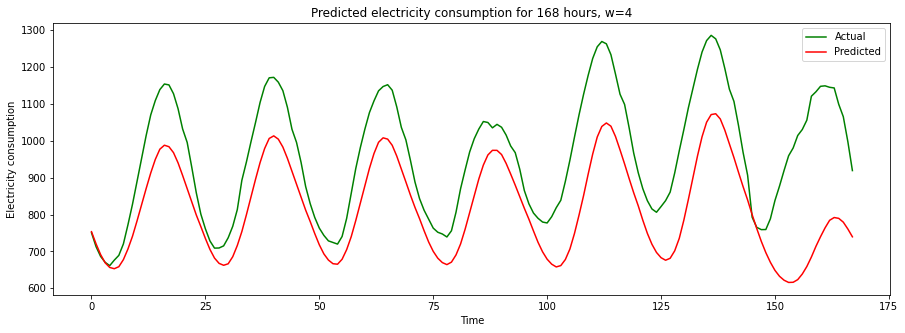

Epoch 1/5
219/219 [==============================] - 9s 30ms/step - loss: 0.0182 - val_loss: 0.0056
Epoch 2/5
219/219 [==============================] - 6s 28ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 3/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0054 - val_loss: 0.0064
Epoch 4/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 5/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0046 - val_loss: 0.0052


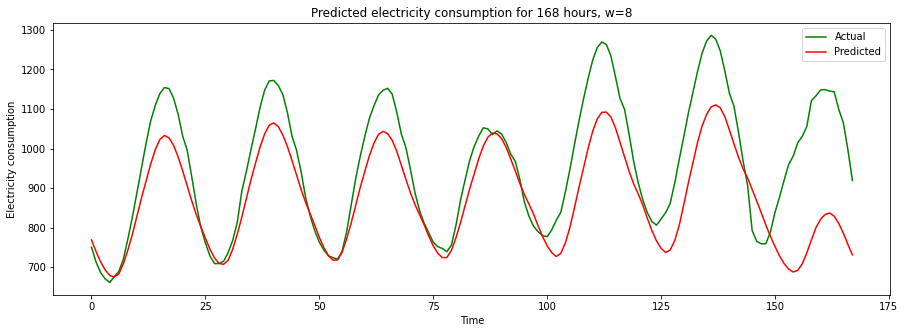

Epoch 1/5
327/327 [==============================] - 12s 30ms/step - loss: 0.0180 - val_loss: 0.0312
Epoch 2/5
327/327 [==============================] - 9s 29ms/step - loss: 0.0064 - val_loss: 0.0165
Epoch 3/5
327/327 [==============================] - 10s 29ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 4/5
327/327 [==============================] - 10s 29ms/step - loss: 0.0045 - val_loss: 0.0087
Epoch 5/5
327/327 [==============================] - 10s 30ms/step - loss: 0.0050 - val_loss: 0.0077


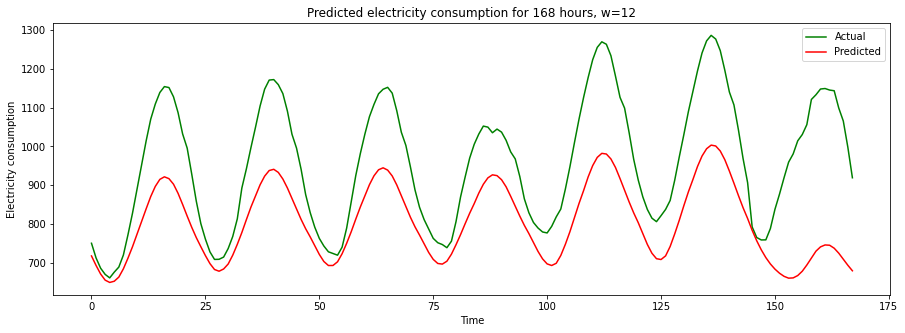

Epoch 1/5
434/434 [==============================] - 16s 31ms/step - loss: 0.0232 - val_loss: 0.0163
Epoch 2/5
434/434 [==============================] - 13s 30ms/step - loss: 0.0087 - val_loss: 0.0103
Epoch 3/5
434/434 [==============================] - 13s 30ms/step - loss: 0.0050 - val_loss: 0.0095
Epoch 4/5
434/434 [==============================] - 13s 29ms/step - loss: 0.0055 - val_loss: 0.0101
Epoch 5/5
434/434 [==============================] - 13s 30ms/step - loss: 0.0052 - val_loss: 0.0096


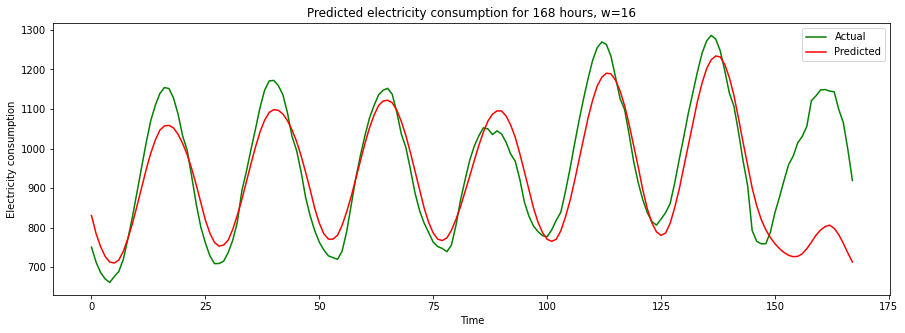

Epoch 1/5
542/542 [==============================] - 19s 31ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 2/5
542/542 [==============================] - 16s 30ms/step - loss: 0.0057 - val_loss: 0.0109
Epoch 3/5
542/542 [==============================] - 17s 30ms/step - loss: 0.0056 - val_loss: 0.0118
Epoch 4/5
542/542 [==============================] - 17s 31ms/step - loss: 0.0055 - val_loss: 0.0119
Epoch 5/5
542/542 [==============================] - 17s 31ms/step - loss: 0.0052 - val_loss: 0.0125


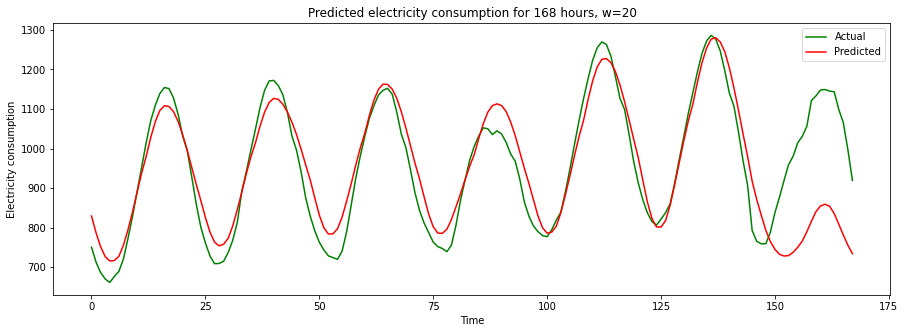

In [87]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)

def test_time_steps(df, t=24, w=4):
  n_rows, n_cols = df.shape
  train = df.iloc[:n_rows-1008]
  test = df.iloc[-1008:] #is the size important?

  min_max_scaler = MinMaxScaler(feature_range=(0,1))
  train_scaled = min_max_scaler.fit_transform(train)
  train_scaled = pd.DataFrame(train_scaled)
  
  test_scaled = min_max_scaler.fit_transform(test)
  test_scaled = pd.DataFrame(test_scaled)

  X_test = pd.DataFrame(test_scaled.iloc[:, 1:])
  y_test = pd.DataFrame(test_scaled.iloc[:, 0])
  X_test.columns = test.columns[1:] #name the columns
  y_test.columns = test.columns[:1] #name the columns

  X_train = pd.DataFrame(train_scaled.iloc[:, 1:])
  y_train = pd.DataFrame(train_scaled.iloc[:, 0])
  X_train.columns = train.columns[1:] #put back the column names
  y_train.columns = train.columns[:1]

  X_train_steps, y_train_steps = create_dataset(X_train, y_train, t)
  X_test_steps, y_test_steps = create_dataset(X_test, y_test, t)

  model = Sequential()
  model.add(LSTM(units=100,
                 activation='relu',
                 return_sequences=True, 
                 input_shape=(X_train_steps.shape[1], 
                              X_train_steps.shape[2])))
  model.add(LSTM(units=100, activation='relu'))
  model.add(Dense(1))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', 
                optimizer=tf.keras.optimizers.Adam(0.001))

  steps = 24 * 7 * w + t
  history = model.fit(
      X_train_steps[len(X_train_steps)-steps:,:], 
      y_train_steps[len(y_train_steps)-steps:],
      epochs=5,
      batch_size=5,
      validation_split=0.2,
      verbose=1,
      shuffle=False)

  y_pred = model.predict(X_test_steps)
  n_rows = y_pred.shape[0] 
  n_features = X_train_steps.shape[2]

  predicted_np = np.column_stack((y_pred, 
                                  np.ones((n_rows, n_features)) ))
  predicted_inverse = min_max_scaler.inverse_transform(predicted_np)

  actual_np = np.column_stack((y_test_steps, 
                               np.ones((n_rows, n_features)) ))
  actual_inverse = min_max_scaler.inverse_transform(actual_np)

  return actual_inverse, predicted_inverse
  
df_north = dfs[0].reset_index()
df_north = df_north.drop(['level_0', 
                          'index'], axis=1) #dropped some low-correlation features
df_north = df_north[df_north['Month'] == 6] #only get data for the month of June
print(f'ERCOT weather region {df_north.columns[0]}')
to_drop = view_variance_threshold(df_north)
df_north = df_north.drop(to_drop, axis=1)

weeks = [4,8,12,16,20]
for week in weeks:
  actual, predicted = test_time_steps(df_north, t=24, w=week)

  plt.figure(figsize=(15,5))
  plt.plot(actual[-168:,0], color='green', label = 'Actual')
  plt.plot(predicted[-168:,0], color='red', label = 'Predicted')
  plt.title(f'Predicted electricity consumption for 168 hours, w={week}')
  plt.xlabel('Time')
  plt.ylabel('Electricity consumption')
  plt.legend()
  plt.show()

ERCOT weather region South Central
Epoch 1/5
165/165 [==============================] - 6s 26ms/step - loss: 0.0294 - val_loss: 0.0058
Epoch 2/5
165/165 [==============================] - 4s 22ms/step - loss: 0.0070 - val_loss: 0.0033
Epoch 3/5
165/165 [==============================] - 4s 22ms/step - loss: 0.0057 - val_loss: 0.0031
Epoch 4/5
165/165 [==============================] - 4s 22ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 5/5
165/165 [==============================] - 4s 22ms/step - loss: 0.0055 - val_loss: 0.0052


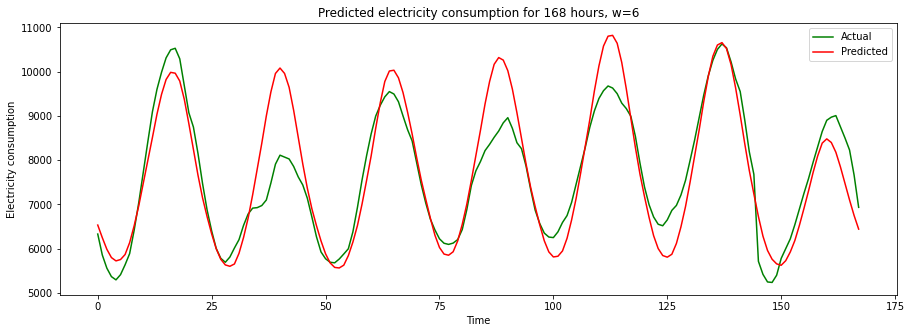

Epoch 1/5
219/219 [==============================] - 9s 31ms/step - loss: 0.0454 - val_loss: 0.0072
Epoch 2/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0122 - val_loss: 0.0107
Epoch 3/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0068 - val_loss: 0.0105
Epoch 4/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0063 - val_loss: 0.0092
Epoch 5/5
219/219 [==============================] - 6s 30ms/step - loss: 0.0059 - val_loss: 0.0081


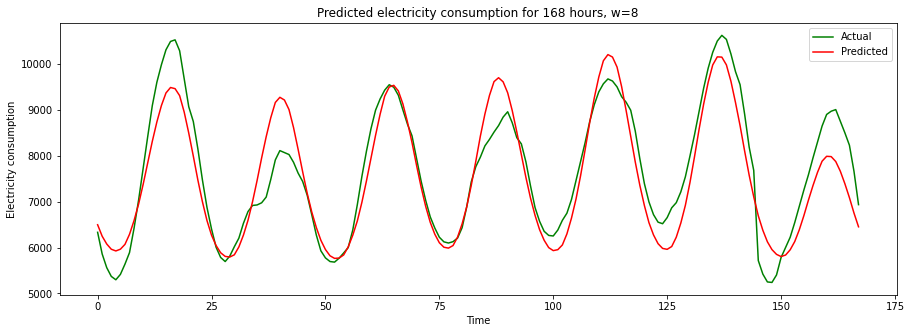

Epoch 1/5
273/273 [==============================] - 11s 31ms/step - loss: 0.0128 - val_loss: 0.0083
Epoch 2/5
273/273 [==============================] - 8s 30ms/step - loss: 0.0053 - val_loss: 0.0067
Epoch 3/5
273/273 [==============================] - 8s 30ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 4/5
273/273 [==============================] - 8s 30ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 5/5
273/273 [==============================] - 8s 30ms/step - loss: 0.0038 - val_loss: 0.0043


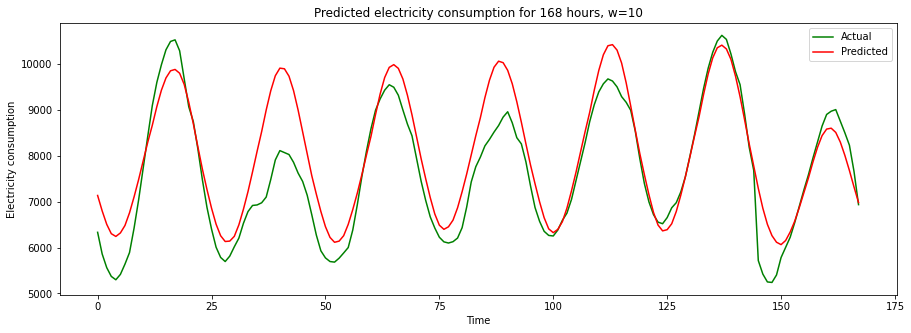

In [86]:
df_sc = dfs[1].reset_index()
df_sc = df_sc.drop(['level_0', 
                    'index', 
                    'visibilityMiles'], axis=1)
df_sc = df_sc[df_sc['Month'] == 6]
print(f'ERCOT weather region {df_sc.columns[0]}')
to_drop = view_variance_threshold(df_sc)
df_sc = df_sc.drop(to_drop, axis=1)

weeks = [6,8,10]
for week in weeks:
  actual, predicted = test_time_steps(df_sc, t=24, w=week)

  plt.figure(figsize=(15,5))
  plt.plot(actual[-168:,0], color='green', label = 'Actual')
  plt.plot(predicted[-168:,0], color='red', label = 'Predicted')
  plt.title(f'Predicted electricity consumption for 168 hours, w={week}')
  plt.xlabel('Time')
  plt.ylabel('Electricity consumption')
  plt.legend()
  plt.show()